In [ ]:
# @title Import Library
import os
import numpy as np
import pandas as pd
import ast
import json
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
from scipy.stats import loguniform, uniform
from scipy.stats import randint
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [ ]:
# @title Mount Drive and Path Configuration
from google.colab import drive
drive.mount('/content/drive/')

project_path = "/content/drive/MyDrive/Project/PBI Home Credit Indonesia-Data Scientist Intern"
data_path = f"{project_path}/Datasets"
output_path = f"{project_path}/Outputs/All Outputs"
model_output_path = f"{project_path}/Outputs/Model Outputs"
os.makedirs(model_output_path, exist_ok=True)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Data 1

In [ ]:
# @title Load Dataset (Scaled for LR)
train = pd.read_csv(f"{output_path}/train_selected_scaled.csv")
print("Train shape:", train.shape)
display(train.head())

Train shape: (307511, 123)


,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 7,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick"
0,1,-0.577538,0.142129,-0.478095,-0.166143,-0.507236,-0.149452,1.506880,-0.456215,0.379837,...,-0.461015,2.218375,-0.188513,1.876900,-0.149481,-0.239507,-0.377813,-0.161651,-1.616246,1.935056
1,0,-0.577538,0.426792,1.725450,0.592683,1.600873,-1.252750,-0.166821,-0.460115,1.078697,...,-0.461015,-0.450780,-0.188513,-0.532794,-0.149481,-0.239507,-0.377813,-0.161651,-1.616246,-0.516781
2,0,-0.577538,-0.427196,-1.152888,-1.404669,-1.092145,-0.783451,-0.689509,-0.453299,0.206116,...,-0.461015,-0.450780,-0.188513,-0.532794,-0.149481,-0.239507,-0.377813,-0.161651,0.618718,-0.516781
3,0,-0.577538,-0.142533,-0.711430,0.177874,-0.653463,-0.928991,-0.680114,-0.473217,-1.375829,...,-0.461015,2.218375,-0.188513,1.876900,-0.149481,-0.239507,-0.377813,-0.161651,0.618718,-0.516781
4,0,-0.577538,-0.199466,-0.213734,-0.361749,-0.068554,0.563570,-0.892535,-0.473210,0.191639,...,-0.461015,-0.450780,-0.188513,-0.532794,-0.149481,-0.239507,-0.377813,-0.161651,0.618718,-0.516781


In [ ]:
# @title Separate Features & Target
target_col = "TARGET"
X = train.drop(columns=[target_col])
y = train[target_col]
print("X shape:", X.shape, "| y shape:", y.shape)

X shape: (307511, 122) | y shape: (307511,)


In [ ]:
# @title Split Train Validation Test
# Train Test 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_test:", X_test.shape, "| y_test :", y_test.shape)

# Sample Tuning
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=0.3, stratify=y_train, random_state=42)
print("\n📊 Sample untuk Tuning (30% dari train):", X_sample.shape, y_sample.shape)

# Cross Validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
print("\n✅ StratifiedKFold siap dipakai untuk cross-validation (3-fold)")

X_train: (246008, 122) | y_train: (246008,)
X_test: (61503, 122) | y_test : (61503,)

📊 Sample untuk Tuning (30% dari train): (73802, 122) (73802,)

✅ StratifiedKFold siap dipakai untuk cross-validation (3-fold)


# Logistic Regression

In [ ]:
# @title Hyperparameter Tuning
# Hyperparameter
param_dist_lr = {"penalty": ["l1", "l2"],
                 "C": loguniform(1e-2, 1e-1),
                 "class_weight": ["balanced"],
                 "max_iter": [1000],
                 "tol": [1e-3]}
lr = LogisticRegression(random_state=42, n_jobs=-1, solver="saga")

# RandomizedSearchCV
rand_lr = RandomizedSearchCV(estimator=lr,
                              param_distributions=param_dist_lr,
                              n_iter=30,
                              scoring="roc_auc",
                              cv=cv,
                              n_jobs=-1,
                              verbose=1,
                              random_state=42)

rand_lr.fit(X_sample, y_sample)

# Save tuning results
cv_results_lr = pd.DataFrame(rand_lr.cv_results_)
cv_results_lr = cv_results_lr.sort_values("rank_test_score", ascending=True)
cv_results_lr.to_csv(f"{model_output_path}/lr_randomsearch_results.csv", index=False)

best_params_lr = rand_lr.best_params_
best_score_lr = rand_lr.best_score_
with open(f"{model_output_path}/lr_best_params.json", "w") as f:
    json.dump({"best_params": best_params_lr,
               "best_cv_roc_auc": best_score_lr}, f)

print("✅ Hyperparameter tuning Logistic Regression selesai")
print("✅ Best Params:", best_params_lr)
print("✅ Best CV ROC-AUC:", best_score_lr)
print(f"Hasil tuning disimpan di: {model_output_path}")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
✅ Hyperparameter tuning Logistic Regression selesai
✅ Best Params: {'C': np.float64(0.040893394339653055), 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l1', 'tol': 0.001}
✅ Best CV ROC-AUC: 0.7490599381939597
Hasil tuning disimpan di: /content/drive/MyDrive/Project/PBI Home Credit Indonesia-Data Scientist Intern/Outputs/Model Outputs


In [ ]:
# @title Train Final with Best Params
with open(f"{model_output_path}/lr_best_params.json", "r") as f:
    best_data = json.load(f)
best_params_lr = best_data["best_params"]
best_score_lr = best_data["best_cv_roc_auc"]
print("✅ Loaded Best Params:", best_params_lr)
print("✅ Best CV ROC-AUC:", best_score_lr)

final_lr = LogisticRegression(**best_params_lr, random_state=42, n_jobs=-1, solver="saga")
final_lr.fit(X_train, y_train)
print("✅ Final Logistic Regression dilatih dengan seluruh training data")

# Save Final Model
model_path = f"{model_output_path}/final_lr_model.pkl"
joblib.dump(final_lr, model_path)
print(f"✅ Model Logistic Regression disimpan ke: {model_path}")

✅ Loaded Best Params: {'C': 0.040893394339653055, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l1', 'tol': 0.001}
✅ Best CV ROC-AUC: 0.7490599381939597
✅ Final Logistic Regression dilatih dengan seluruh training data
✅ Model Logistic Regression disimpan ke: /content/drive/MyDrive/Project/PBI Home Credit Indonesia-Data Scientist Intern/Outputs/Model Outputs/final_lr_model.pkl


In [ ]:
# @title Predict Data Test
# Ambil SK_ID_CURR
train_path = f"{output_path}/train_merged.csv"
train_raw = pd.read_csv(train_path)
train_ids = train_raw["SK_ID_CURR"]

# Predict Data Test
y_test_pred_proba_lr = final_lr.predict_proba(X_test)[:, 1]
y_test_pred_lr = (y_test_pred_proba_lr >= 0.5).astype(int)

test_predictions_lr = pd.DataFrame({"SK_ID_CURR": train_ids.iloc[y_test.index].values,
                                    "TARGET_TRUE": y_test.values,
                                    "TARGET_PROBA_LR": y_test_pred_proba_lr,
                                    "TARGET_PRED_LR": y_test_pred_lr})
test_pred_path_lr = f"{model_output_path}/lr_test_predictions.csv"
test_predictions_lr.to_csv(test_pred_path_lr, index=False)

print(f"✅ Prediksi test split Logistic Regression disimpan ke: {test_pred_path_lr}")
display(test_predictions_lr.head())

✅ Prediksi test split Logistic Regression disimpan ke: /content/drive/MyDrive/Project/PBI Home Credit Indonesia-Data Scientist Intern/Outputs/Model Outputs/lr_test_predictions.csv


,SK_ID_CURR,TARGET_TRUE,TARGET_PROBA_LR,TARGET_PRED_LR
0,396899,0,0.295706,0
1,322041,0,0.252785,0
2,220127,0,0.745487,1
3,251531,0,0.491019,0
4,345558,0,0.457269,0


In [ ]:
# @title Evaluation Metrics
# Prediksi
y_test_pred_proba_lr = final_lr.predict_proba(X_test)[:, 1]
y_test_pred_lr = final_lr.predict(X_test)

# Hitung metric
roc_auc_lr = roc_auc_score(y_test, y_test_pred_proba_lr)
accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
precision_lr = precision_score(y_test, y_test_pred_lr)
recall_lr = recall_score(y_test, y_test_pred_lr)
f1_lr = f1_score(y_test, y_test_pred_lr)

# Tampilkan
print("✅ Evaluation Metrics Logistic Regression (Test Set)")
print(f"ROC-AUC   : {roc_auc_lr:.4f}")
print(f"Accuracy  : {accuracy_lr:.4f}")
print(f"Precision : {precision_lr:.4f}")
print(f"Recall    : {recall_lr:.4f}")
print(f"F1 Score  : {f1_lr:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_lr, digits=4))

✅ Evaluation Metrics Logistic Regression (Test Set)
ROC-AUC   : 0.7526
Accuracy  : 0.6882
Precision : 0.1619
Recall    : 0.6852
F1 Score  : 0.2619

Classification Report:
              precision    recall  f1-score   support

           0     0.9614    0.6884    0.8023     56538
           1     0.1619    0.6852    0.2619      4965

    accuracy                         0.6882     61503
   macro avg     0.5616    0.6868    0.5321     61503
weighted avg     0.8968    0.6882    0.7587     61503



# Data 2

In [ ]:
# @title Load Dataset (NoScale for RF and LightGBM)
trains = pd.read_csv(f"{output_path}/train_selected_unscaled.csv")
print("Train (NoScale) shape:", trains.shape)
display(trains.head())

Train (NoScale) shape: (307511, 123)


,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 7,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick"
0,1,-0.577538,0.142129,-0.478095,-0.166143,-0.507236,-0.149452,1.506880,-0.456215,0.379837,...,-0.461015,2.218375,-0.188513,1.876900,-0.149481,-0.239507,-0.377813,-0.161651,-1.616246,1.935056
1,0,-0.577538,0.426792,1.725450,0.592683,1.600873,-1.252750,-0.166821,-0.460115,1.078697,...,-0.461015,-0.450780,-0.188513,-0.532794,-0.149481,-0.239507,-0.377813,-0.161651,-1.616246,-0.516781
2,0,-0.577538,-0.427196,-1.152888,-1.404669,-1.092145,-0.783451,-0.689509,-0.453299,0.206116,...,-0.461015,-0.450780,-0.188513,-0.532794,-0.149481,-0.239507,-0.377813,-0.161651,0.618718,-0.516781
3,0,-0.577538,-0.142533,-0.711430,0.177874,-0.653463,-0.928991,-0.680114,-0.473217,-1.375829,...,-0.461015,2.218375,-0.188513,1.876900,-0.149481,-0.239507,-0.377813,-0.161651,0.618718,-0.516781
4,0,-0.577538,-0.199466,-0.213734,-0.361749,-0.068554,0.563570,-0.892535,-0.473210,0.191639,...,-0.461015,-0.450780,-0.188513,-0.532794,-0.149481,-0.239507,-0.377813,-0.161651,0.618718,-0.516781


In [ ]:
# @title Separate Features & Target
target_col = "TARGET"
X = trains.drop(columns=[target_col])
y = trains[target_col]
print("X:", X.shape, "y:", y.shape)

X: (307511, 122) y: (307511,)


In [ ]:
# @title Split Train Validation Test
# Train Test 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_test:", X_test.shape, "| y_test:", y_test.shape)

# Sample Tuning
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=0.3, stratify=y_train, random_state=42)
print("\n📊 Sample untuk Tuning (30% dari train):", X_sample.shape, y_sample.shape)

# Cross Validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
print("\n✅ StratifiedKFold siap dipakai untuk cross-validation (3-fold)")

X_train: (246008, 122) | y_train: (246008,)
X_test: (61503, 122) | y_test: (61503,)

📊 Sample untuk Tuning (30% dari train): (73802, 122) (73802,)

✅ StratifiedKFold siap dipakai untuk cross-validation (3-fold)


# Random Forest

In [ ]:
# @title Hyperparameter Tuning
param_dist_rf = {"n_estimators": randint(100,200),
                 "max_depth": randint(5, 10),
                 "min_samples_split": [5, 10],
                 "min_samples_leaf": [2, 4],
                 "max_features": ["sqrt"],
                 "class_weight": ["balanced"]}
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rand_rf = RandomizedSearchCV(estimator=rf,
                             param_distributions=param_dist_rf,
                             n_iter=30,
                             scoring="roc_auc",
                             cv=cv,
                             n_jobs=-1,
                             verbose=1,
                             random_state=42)
rand_rf.fit(X_sample, y_sample)

# Simpan hasil tuning lengkap (urut terbaik dulu)
cv_results_rf = pd.DataFrame(rand_rf.cv_results_)
cv_results_rf = cv_results_rf.sort_values("rank_test_score", ascending=True)
cv_results_rf.to_csv(f"{model_output_path}/rf_randomsearch_results.csv", index=False)

# Simpan best params + best score ke JSON
best_params_rf = rand_rf.best_params_
best_score_rf = rand_rf.best_score_
with open(f"{model_output_path}/rf_best_params.json", "w") as f:
    json.dump({"best_params": best_params_rf,
               "best_cv_roc_auc": best_score_rf}, f)

print("✅ Hyperparameter tuning Random Forest selesai")
print("✅ Best Params:", best_params_rf)
print("✅ Best CV ROC-AUC:", best_score_rf)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
✅ Hyperparameter tuning Random Forest selesai
✅ Best Params: {'class_weight': 'balanced', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 189}
✅ Best CV ROC-AUC: 0.7322475186350479


In [ ]:
# @title Train Final with Best Params
with open(f"{model_output_path}/rf_best_params.json", "r") as f:
    best_data_rf = json.load(f)
best_params_rf = best_data_rf["best_params"]
best_score_rf  = best_data_rf["best_cv_roc_auc"]
print("✅ Loaded Best Params RF:", best_params_rf)
print("✅ Best CV ROC-AUC RF:", best_score_rf)

final_rf = RandomForestClassifier(**best_params_rf, random_state=42, n_jobs=-1)
final_rf.fit(X_train, y_train)
print("✅ Final Random Forest dilatih dengan seluruh training data")

# Simpan final model
rf_model_path = f"{model_output_path}/final_rf_model.pkl"
joblib.dump(final_rf, rf_model_path)
print(f"✅ Model Random Forest disimpan ke: {rf_model_path}")

✅ Loaded Best Params RF: {'class_weight': 'balanced', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 189}
✅ Best CV ROC-AUC RF: 0.7322475186350479
✅ Final Random Forest dilatih dengan seluruh training data
✅ Model Random Forest disimpan ke: /content/drive/MyDrive/Project/PBI Home Credit Indonesia-Data Scientist Intern/Outputs/Model Outputs/final_rf_model.pkl


In [ ]:
# @title Predict Data Test
# Ambil SK_ID_CURR dari dataset train_merged dan test_merged
train_path = f"{output_path}/train_merged.csv"
train_raw = pd.read_csv(train_path)
train_ids = train_raw["SK_ID_CURR"]

# Predict Data Test
y_test_pred_proba_rf = final_rf.predict_proba(X_test)[:, 1]
y_test_pred_rf = (y_test_pred_proba_rf >= 0.5).astype(int)

test_predictions_rf = pd.DataFrame({"SK_ID_CURR": train_ids.iloc[y_test.index].values,  # index sesuai X_test
                                    "TARGET_TRUE": y_test.values,
                                    "TARGET_PROBA_RF": y_test_pred_proba_rf,
                                    "TARGET_PRED_RF": y_test_pred_rf})
test_pred_path_rf = f"{model_output_path}/rf_test_predictions.csv"
test_predictions_rf.to_csv(test_pred_path_rf, index=False)

print(f"✅ Prediksi test split Random Forest disimpan ke: {test_pred_path_rf}")
display(test_predictions_rf.head())

✅ Prediksi test split Random Forest disimpan ke: /content/drive/MyDrive/Project/PBI Home Credit Indonesia-Data Scientist Intern/Outputs/Model Outputs/rf_test_predictions.csv


,SK_ID_CURR,TARGET_TRUE,TARGET_PROBA_RF,TARGET_PRED_RF
0,396899,0,0.454250,0
1,322041,0,0.393077,0
2,220127,0,0.566136,1
3,251531,0,0.466465,0
4,345558,0,0.517999,1


In [ ]:
# @title Evaluation Metrics
# Prediksi
y_test_pred_proba_rf = final_rf.predict_proba(X_test)[:, 1]
y_test_pred_rf = final_rf.predict(X_test)

# Hitung metric
roc_auc_rf = roc_auc_score(y_test, y_test_pred_proba_rf)
accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
precision_rf = precision_score(y_test, y_test_pred_rf)
recall_rf = recall_score(y_test, y_test_pred_rf)
f1_rf = f1_score(y_test, y_test_pred_rf)

# Tampilkan
print("✅ Evaluation Metrics Random Forest (Test Set)")
print(f"ROC-AUC   : {roc_auc_rf:.4f}")
print(f"Accuracy  : {accuracy_rf:.4f}")
print(f"Precision : {precision_rf:.4f}")
print(f"Recall    : {recall_rf:.4f}")
print(f"F1 Score  : {f1_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_rf, digits=4))

✅ Evaluation Metrics Random Forest (Test Set)
ROC-AUC   : 0.7395
Accuracy  : 0.6849
Precision : 0.1583
Recall    : 0.6721
F1 Score  : 0.2562

Classification Report:
              precision    recall  f1-score   support

           0     0.9597    0.6861    0.8001     56538
           1     0.1583    0.6721    0.2562      4965

    accuracy                         0.6849     61503
   macro avg     0.5590    0.6791    0.5282     61503
weighted avg     0.8950    0.6849    0.7562     61503



# LightGBM

In [ ]:
import re
def clean_cols(df):
    df.columns = [re.sub(r"[^0-9a-zA-Z_]", "_", str(c)) for c in df.columns]
    return df

X_sample = clean_cols(X_sample)
X_train  = clean_cols(X_train)
X_test   = clean_cols(X_test)

In [ ]:
# @title Hyperparameter Tuning
param_dist_lgb = {"num_leaves": [31, 63, 95],
                  "max_depth": [-1, 10],
                  "learning_rate": [0.01, 0.1],
                  "n_estimators": [800],
                  "subsample": [0.8, 1.0],
                  "colsample_bytree": [0.8, 1.0],
                  "min_child_samples": [50, 80]}

lgb_estimator = lgb.LGBMClassifier(random_state=42,
                                   n_jobs=-1,
                                   objective="binary",
                                   boosting_type="gbdt")

# RandomizedSearchCV
rand_lgb = RandomizedSearchCV(estimator=lgb_estimator,
                              param_distributions=param_dist_lgb,
                              n_iter=30,
                              scoring="roc_auc",
                              cv=cv,
                              n_jobs=-1,
                              verbose=1,
                              random_state=42)

rand_lgb.fit(X_sample, y_sample)

# Simpan hasil tuning lengkap (urut terbaik dulu)
cv_results_lgb = pd.DataFrame(rand_lgb.cv_results_)
cv_results_lgb = cv_results_lgb.sort_values("rank_test_score", ascending=True)
cv_results_lgb.to_csv(f"{model_output_path}/lgb_randomsearch_results.csv", index=False)

# Simpan best params + best score ke JSON
best_params_lgb = rand_lgb.best_params_
best_score_lgb = rand_lgb.best_score_
with open(f"{model_output_path}/lgb_best_params.json", "w") as f:
    json.dump({"best_params": best_params_lgb,
               "best_cv_roc_auc": best_score_lgb}, f)

print("✅ Hyperparameter tuning LightGBM selesai")
print("✅ Best Params:", best_params_lgb)
print("✅ Best CV ROC-AUC:", best_score_lgb)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 5958, number of negative: 67844
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11695
[LightGBM] [Info] Number of data points in the train set: 73802, number of used features: 122
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432476
[LightGBM] [Info] Start training from score -2.432476
✅ Hyperparameter tuning LightGBM selesai
✅ Best Params: {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 800, 'min_child_samples': 50, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
✅ Best CV ROC-AUC: 0.7550896460156661


In [ ]:
# @title Train Final LightGBM with Best Params
with open(f"{model_output_path}/lgb_best_params.json", "r") as f:
    best_data_lgb = json.load(f)
best_params_lgb = best_data_lgb["best_params"]
best_score_lgb  = best_data_lgb["best_cv_roc_auc"]
print("✅ Loaded Best Params LightGBM:", best_params_lgb)
print("✅ Best CV ROC-AUC LightGBM:", best_score_lgb)

# Hitung scale_pos_weight untuk imbalance handling
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print("✅ scale_pos_weight:", scale_pos_weight)

final_lgb = lgb.LGBMClassifier(**best_params_lgb,
                               random_state=42,
                               n_jobs=-1,
                               objective="binary",
                               boosting_type="gbdt",
                               scale_pos_weight=scale_pos_weight)
final_lgb.fit(X_train, y_train)
print("✅ Final model LightGBM dilatih dengan seluruh training data")

# Simpan final model
model_path = f"{model_output_path}/final_lgb_model.pkl"
joblib.dump(final_lgb, model_path)
print(f"✅ Model LightGBM disimpan ke: {model_path}")

✅ Loaded Best Params LightGBM: {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 800, 'min_child_samples': 50, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
✅ Best CV ROC-AUC LightGBM: 0.7550896460156661
✅ scale_pos_weight: 11.38710976837865
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.419872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11955
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 122
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
✅ Final model LightGBM dilatih dengan seluruh training data
✅ Model LightGBM disimpan ke: /content/drive/MyDrive/Project/PBI Home Credit Indonesia-Data Scientist Intern/Outputs/Model Outputs/final_lgb_model.pkl


In [ ]:
# @title Predict Data Test LightGBM
# Ambil SK_ID_CURR dari dataset train_merged dan test_merged
train_path = f"{output_path}/train_merged.csv"
train_raw = pd.read_csv(train_path)
train_ids = train_raw["SK_ID_CURR"]

# Predict Data Test dengan LightGBM
y_test_pred_proba_lgb = final_lgb.predict_proba(X_test)[:, 1]
y_test_pred_lgb = (y_test_pred_proba_lgb >= 0.5).astype(int)

test_predictions_lgb = pd.DataFrame({"SK_ID_CURR": train_ids.iloc[y_test.index].values,
                                     "TARGET_TRUE": y_test.values,
                                     "TARGET_PROBA_LGB": y_test_pred_proba_lgb,
                                     "TARGET_PRED_LGB": y_test_pred_lgb})
test_pred_path_lgb = f"{model_output_path}/lgb_test_predictions.csv"
test_predictions_lgb.to_csv(test_pred_path_lgb, index=False)

print(f"✅ Prediksi test split LightGBM disimpan ke: {test_pred_path_lgb}")
display(test_predictions_lgb.head())

✅ Prediksi test split LightGBM disimpan ke: /content/drive/MyDrive/Project/PBI Home Credit Indonesia-Data Scientist Intern/Outputs/Model Outputs/lgb_test_predictions.csv


,SK_ID_CURR,TARGET_TRUE,TARGET_PROBA_LGB,TARGET_PRED_LGB
0,396899,0,0.346478,0
1,322041,0,0.196581,0
2,220127,0,0.784054,1
3,251531,0,0.413597,0
4,345558,0,0.464876,0


In [ ]:
# @title Evaluation Metrics LightGBM
# Predict
y_test_pred_proba_lgb = final_lgb.predict_proba(X_test)[:, 1]

# Cari threshold optimal (maximize F1)
prec, rec, thresh = precision_recall_curve(y_test, y_test_pred_proba_lgb)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresh[best_idx]
print("✅ Best Threshold LightGBM (maximize F1):", best_threshold)

# Prediksi class dengan threshold optimal
y_test_pred_lgb = (y_test_pred_proba_lgb >= best_threshold).astype(int)

# Hitung metrics
roc_auc_lgb = roc_auc_score(y_test, y_test_pred_proba_lgb)
accuracy_lgb = accuracy_score(y_test, y_test_pred_lgb)
precision_lgb = precision_score(y_test, y_test_pred_lgb)
recall_lgb = recall_score(y_test, y_test_pred_lgb)
f1_lgb = f1_score(y_test, y_test_pred_lgb)

# Tampilkan hasil
print("\n✅ Evaluation Metrics LightGBM (Test Set)")
print(f"ROC-AUC   : {roc_auc_lgb:.4f}")
print(f"Accuracy  : {accuracy_lgb:.4f}")
print(f"Precision : {precision_lgb:.4f}")
print(f"Recall    : {recall_lgb:.4f}")
print(f"F1 Score  : {f1_lgb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_lgb, digits=4))

✅ Best Threshold LightGBM (maximize F1): 0.6523419481522194

✅ Evaluation Metrics LightGBM (Test Set)
ROC-AUC   : 0.7666
Accuracy  : 0.8458
Precision : 0.2484
Recall    : 0.4489
F1 Score  : 0.3198

Classification Report:
              precision    recall  f1-score   support

           0     0.9479    0.8807    0.9131     56538
           1     0.2484    0.4489    0.3198      4965

    accuracy                         0.8458     61503
   macro avg     0.5981    0.6648    0.6164     61503
weighted avg     0.8914    0.8458    0.8652     61503



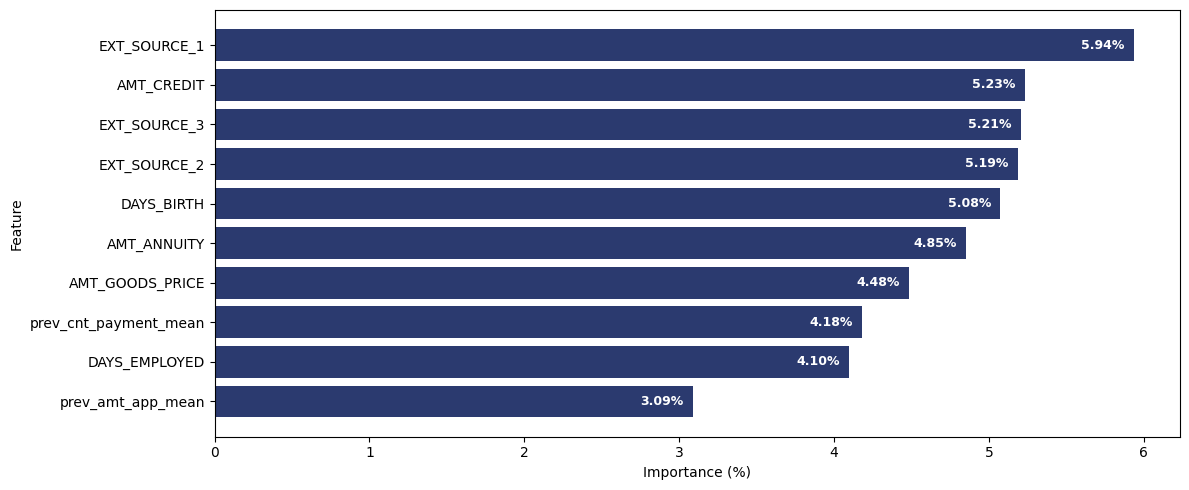

In [ ]:
# @title Feature Importance LightGBM (Top 10)
importances = final_lgb.feature_importances_
features = X_train.columns
feat_imp_lgb = pd.DataFrame({"feature": features, "importance": importances})
feat_imp_lgb["importance_pct"] = feat_imp_lgb["importance"] / feat_imp_lgb["importance"].sum() * 100
top_n = 10
feat_plot = feat_imp_lgb.sort_values("importance", ascending=False).head(top_n)
feat_plot = feat_plot.sort_values("importance", ascending=True)

# Bar chart
custom_color = (43/255, 58/255, 111/255)
fig, ax = plt.subplots(figsize=(12, 5), facecolor="none")
ax.set_facecolor("none")
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)
bars = plt.barh(feat_plot["feature"], feat_plot["importance_pct"], color=custom_color)
for bar, val in zip(bars, feat_plot["importance_pct"]):
    plt.text(bar.get_width() - 0.2,
             bar.get_y() + bar.get_height()/2,
             f"{val:.2f}%",
             ha='center', va='center',
             fontsize=9, color="white", fontweight="bold")

ax.set_xlabel("Importance (%)")
ax.set_ylabel("Feature")
plt.tight_layout()
plt.savefig("lgbm_feature_importance.png", dpi=1000, transparent=True)
plt.show()

In [ ]:
# @title Top 10 Feature Importance (LightGBM)
# Ambil feature importance dari model LGBM final
importances = final_lgb.feature_importances_
features = X_train.columns
feat_imp_lgb = pd.DataFrame({"feature": features, "importance": importances})
feat_imp_lgb["importance_pct"] = feat_imp_lgb["importance"] / feat_imp_lgb["importance"].sum() * 100
top_n = 10
feat_plot = feat_imp_lgb.sort_values("importance", ascending=False).head(top_n)
feat_plot = feat_plot.sort_values("importance", ascending=True)
colors = ['rgb(43, 58, 111)' for _ in feat_plot["importance"]]
# Bar chart
trace = go.Bar(x=feat_plot["importance_pct"],
               y=feat_plot["feature"],
               orientation="h",
               marker=dict(color=colors),
               text=[f"{val:.2f}%" for val in feat_plot["importance_pct"]],
               textposition="auto")
# Layout chart
layout = go.Layout(title=dict(text=f"Top {top_n} Feature Importance (LightGBM)",
                              x=0.5, xanchor='center', yanchor='top',
                              font=dict(size=14, color='black')),
                   xaxis=dict(title="Importance (%)",
                              titlefont=dict(size=12, color='black'),
                              tickfont=dict(size=10, color='black'),
                              showgrid=False, showline=True, linecolor='black', linewidth=1),
                   yaxis=dict(title="Feature",
                              titlefont=dict(size=12, color='black'),
                              tickfont=dict(size=10, color='black'),
                              showgrid=False, showline=True, linecolor='black', linewidth=1),
                   plot_bgcolor='rgba(0,0,0,0)',
                   paper_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename="lgbm_feature_importance_pct")